In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from functions import calculate_tss, calculate_hss
import seaborn as sns
import sys
import random

# Read in Data

In [2]:
flares = pd.read_csv("Flares_SEPs_SHMARPs_t-5.dat", sep="\t")  # Adjust the 'sep' parameter according to your file's delimiter.
print(flares.columns)

Index(['t_start', 't_max', 't_end', 'class', 'location', 'AR', 'SEP_Match',
       'intensity', 'coords', 'ang_dist', 'T_OBS', 'ARPNUM', 'NOAA_AR',
       'CAR_ROT', 'USFLUXL', 'R_VALUE', 'MEANGBL_GMM', 'MEANGBZ', 'USFLUXZ',
       'CMASKL', 'LAT_FWT', 'CRLT_OBS', 'LON_FWT', 'CRLN_OBS', 'CDELT1',
       'DSUN_OBS', 'RSUN_OBS', 'ANG_DIST_AR', 'time_diff'],
      dtype='object')


# Check Some Stats

In [3]:
# Separate the DataFrame into positive and negative datasets
positive_flares = flares[flares['SEP_Match'] == True]
negative_flares = flares[flares['SEP_Match'] == False]

# Filter out rows with 'time_diff' less than -3000 for positive flares
positive_flares = positive_flares[positive_flares['time_diff'] >= -3000]
negative_flares = negative_flares[negative_flares['time_diff'] >= -3000]

## Remove SEP-Causing ARs from Negative List (optional)

In [4]:
remove_active = False
if remove_active == True:
    sep_ars = set(positive_flares['AR'])
    print(len(negative_flares))
    negative_flares = negative_flares[~negative_flares['AR'].isin(sep_ars)]
    print(len(negative_flares), negative_flares)

# Find Optimal Parameters (Grid Search)

In [9]:
TN_all = []; FP_all = []; FN_all = []; TP_all = []
accuracy_all = []; cm_all = []

# Combine all data and normalize
predictors = ['USFLUXZ', 'USFLUXL', 'R_VALUE', 'ANG_DIST_AR'] # USFLUXL, R_VALUE,	MEANGBL_GMM, MEANGBZ, USFLUXZ, 'MEANGBZ',
all_data = pd.concat([positive_flares[predictors], negative_flares[predictors]], ignore_index=True) # Combine positive and negative datasets
all_data = all_data.dropna()
scaler = preprocessing.StandardScaler().fit(all_data) # Scale all the data
all_data_scaled = scaler.transform(all_data)

# Now, split back into positive and negative datasets
idxs = np.random.choice(len(negative_flares) - len(positive_flares), size=len(positive_flares), replace=False)
positive_data = all_data_scaled[:len(positive_flares)] 
negative_data = (all_data_scaled[len(positive_flares):])[idxs]

# Now split the positive and negative data into training and validation sets
positive_train, positive_val = train_test_split(positive_data, test_size=0.1, random_state=3)
negative_train, negative_val = train_test_split(negative_data, test_size=0.1, random_state=3)

# Ensure that there are equal number of positive and negative instances in validation set
if len(positive_val) < len(negative_val): negative_val = negative_val[:len(positive_val)]; print('Problem')
elif len(negative_val) < len(positive_val): positive_val = positive_val[:len(negative_val)]; print('Problem')
# Combine back the training and validation datasets
X_train = np.vstack((positive_train, negative_train))
Y_train = np.array([1]*len(positive_train) + [0]*len(negative_train))
X_val = np.vstack((positive_val, negative_val))
Y_val = np.array([1]*len(positive_val) + [0]*len(negative_val))

param_grid = {'C': np.logspace(-3, 3, num=10),  # Values like 0.001, 0.01, 0.1, 1, 10, 100, 1000
              'gamma': np.logspace(-3, 1, num=10),  # Values like 0.001, 0.01, 0.1, 1, 10
              'kernel': ['poly'], #['linear', 'rbf', 'sigmoid'],
              'class_weight': ['balanced'],
              'degree': [1, 2, 3]}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, n_jobs = -1, cv=2)
grid.fit(X_train, Y_train)
params = grid.best_params_
print(params)
# pd.DataFrame(grid.cv_results_).to_csv("./search.csv")
# output_pred = grid.predict(X_val)
# print(output_pred)
# print(Y_val)
# break

Fitting 2 folds for each of 300 candidates, totalling 600 fits
[CV 1/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.001, kernel=poly;, score=0.480 total time=   0.0s
[CV 2/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.001, kernel=poly;, score=0.520 total time=   0.0s
[CV 2/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.0027825594022071257, kernel=poly;, score=0.520 total time=   0.0s
[CV 2/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.007742636826811269, kernel=poly;, score=0.520 total time=   0.0s
[CV 1/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.021544346900318832, kernel=poly;, score=0.480 total time=   0.0s
[CV 2/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.021544346900318832, kernel=poly;, score=0.520 total time=   0.0s
[CV 1/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.0027825594022071257, kernel=poly;, score=0.480 total time=   0.0s
[CV 2/2] END C=0.001, class_weight=balanced, degree=1, gamma=0.059948

# Training

In [49]:
TN_all = []; FP_all = []; FN_all = []; TP_all = []
accuracy_all = []; cm_all = []

# Combine all data and normalize
predictors = ['USFLUXZ', 'R_VALUE', 'ANG_DIST_AR']#, 'MEANGBL_GMM', 'MEANGBZ'] 
all_data = pd.concat([positive_flares[predictors], negative_flares[predictors]], ignore_index=True) # Combine positive and negative datasets
all_data = all_data.dropna()
scaler = preprocessing.StandardScaler().fit(all_data) # Scale all the data
all_data_scaled = scaler.transform(all_data)
# print(all_data)
# all_data_scaled = all_data.to_numpy()
total_runs = 100

for run in range(0,total_runs):
    # Now, split back into positive and negative datasets
    idxs = np.random.choice(len(negative_flares) - len(positive_flares), size=len(positive_flares), replace=False)
    positive_data = all_data_scaled[:len(positive_flares)] 
    negative_data = (all_data_scaled[len(positive_flares):])[idxs]
    # Now split the positive and negative data into training and validation sets
    positive_train, positive_val = train_test_split(positive_data, test_size=0.1, random_state=run)
    negative_train, negative_val = train_test_split(negative_data, test_size=0.1, random_state=run)
    # Ensure that there are equal number of positive and negative instances in validation set
    if len(positive_val) < len(negative_val): negative_val = negative_val[:len(positive_val)]; print('Problem')
    elif len(negative_val) < len(positive_val): positive_val = positive_val[:len(negative_val)]; print('Problem')
    # Combine back the training and validation datasets
    X_train = np.vstack((positive_train, negative_train))
    Y_train = np.array([1]*len(positive_train) + [0]*len(negative_train))
    X_val = np.vstack((positive_val, negative_val))
    Y_val = np.array([1]*len(positive_val) + [0]*len(negative_val))
    # Define SVM parameters (Hyperparameters)
    C = 1 #params['C']
    deg = 1 #params['degree']
    gamma = 10 #params['gamma']
    kernel = 'poly'
    # Create and train the SVM model
    model = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=deg, class_weight='balanced')
    model.fit(X_train, Y_train) #this is the training
    # VALIDATION !!!!!
    output_pred = model.predict(X_val) # Now you can test the model on the validation set
    # Calculate metrics for this specific run
    cm = metrics.confusion_matrix(Y_val, output_pred) # Calculate confusion matrix
    TN, FP, FN, TP = cm.ravel()
    accuracy = metrics.accuracy_score(Y_val, output_pred) # Calculate accuracy
    TN_all.append(TN); FP_all.append(FP); FN_all.append(FN); TP_all.append(TP)
    accuracy_all.append(accuracy); cm_all.append(cm)

# Calculate TSS and HSS

In [50]:
tss_all = []; hss_all = [] # Initialize empty lists to store TSS and HSS for each run
for run in range(total_runs): # Calculate TSS and HSS for each run and store in lists
    tp = cm_all[run][0, 0]; fn = cm_all[run][0, 1]; fp = cm_all[run][1, 0]; tn = cm_all[run][1, 1] # Calculate TP, FN, FP and TN
    tss = calculate_tss(tp, tn, fp, fn); hss = calculate_hss(tp, tn, fp, fn) # Calculate TSS and HSS
    tss_all.append(tss); hss_all.append(hss) # Append

# Plot and Print Results

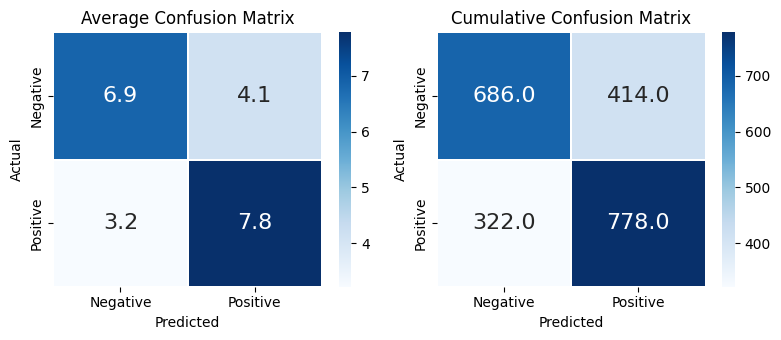

Average ACC for 100 runs: 0.665 +- 0.097
Average TSS for 100 runs: 0.331 +- 0.194
Average HSS for 100 runs: 0.331 +- 0.194


In [51]:
# Calculate average confusion matrix
average_cm = np.array([[np.mean(TN_all), np.mean(FP_all)], [np.mean(FN_all), np.mean(TP_all)]])
labels = ['Negative', 'Positive'] # Define labels
average_cm_df = pd.DataFrame(average_cm, index=labels, columns=labels) # Create DataFrame for average confusion matrix

# Calculate cumulative confusion matrix
cumulative_cm = np.array([[int(sum(TN_all)), int(sum(FP_all))], [int(sum(FN_all)), int(sum(TP_all))]])
cumulative_cm_df = pd.DataFrame(cumulative_cm, index=labels, columns=labels) # Create DataFrame for cumulative confusion matrix

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
# Plot average confusion matrix
sns.heatmap(average_cm_df, annot=True, annot_kws={"size": 16}, fmt=".1f", cmap='Blues', cbar=True, linewidths=0.3, ax=axes[0])
axes[0].set_title('Average Confusion Matrix'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
# Plot cumulative confusion matrix
sns.heatmap(cumulative_cm_df, annot=True, annot_kws={"size": 16}, fmt=".1f", cmap='Blues', cbar=True, linewidths=0.3, ax=axes[1])
axes[1].set_title('Cumulative Confusion Matrix'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
# Ensure good spacing between the subplots
plt.tight_layout()  
plt.show()

print('Average ACC for {} runs: {} +- {}'.format(total_runs,round(np.mean(accuracy_all),3),round(np.std(accuracy_all),3)))
print('Average TSS for {} runs: {} +- {}'.format(total_runs,round(np.mean(tss_all),3),round(np.std(tss_all),3)))
print('Average HSS for {} runs: {} +- {}'.format(total_runs,round(np.mean(hss_all),3),round(np.std(hss_all),3)))